In [1]:
import json
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import tifffile
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, Normalize, RandomCrop, Compose

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import multiplex_imaging_pipeline.utils as utils
from vit_pytorch import ViT, MAE
from vit_pytorch.slide_mae import SlideMAE


In [5]:
metadata = json.load(open('../data/test_registration/HT397B1_v2/registered/metadata.json'))
metadata

{'downsample_scaler': 0.1,
 'phenocycler_pixels_per_micron': 1.9604911906033102,
 'order': ['HT397B1-S1H3A1U1',
  'HT397B1-S1H3A1U2',
  'HT397B1-S1H3A1U12',
  'HT397B1-S1H3A1U21',
  'HT397B1-S1H3A1U22',
  'HT397B1-S1H3A1U31'],
 'data_type': ['visium', 'codex', 'codex', 'visium', 'codex', 'codex'],
 'slices': ['s0', 's1', 's2', 's3', 's4', 's5']}

In [6]:
fps = sorted(utils.listfiles('/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered',
                     regex='ome.tiff$'))
fps

['/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s1.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s2.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s4.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s5.ome.tiff']

In [7]:
pool = []
for fp in fps:
    channels = utils.get_ome_tiff_channels(fp)
    channels = [utils.R_CHANNEL_MAPPING.get(c, c) for c in channels]
    pool += channels
Counter(pool).most_common()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


[('Bap1', 4),
 ('CD31', 4),
 ('CD45', 4),
 ('CD68', 4),
 ('CD8', 4),
 ('CK19', 4),
 ('COX6c', 4),
 ('DAPI', 4),
 ('ER', 4),
 ('FOXP3', 4),
 ('GATA3', 4),
 ('GLUT1', 4),
 ('HLA-DR', 4),
 ('Her2', 4),
 ('CK14', 4),
 ('Ki67', 4),
 ('MGP', 4),
 ('PLAT/tPA', 4),
 ('PR', 4),
 ('Pan-Cytokeratin', 4),
 ('Podoplanin', 4),
 ('SMA', 4),
 ('Vimentin', 4),
 ('cKit', 4),
 ('CD20', 2),
 ('CD3e', 2),
 ('CD11b', 1),
 ('E-cadherin', 1)]

In [8]:
channels = sorted([c for c, count in Counter(pool).items() if count==len(fps)])
channels

['Bap1',
 'CD31',
 'CD45',
 'CD68',
 'CD8',
 'CK14',
 'CK19',
 'COX6c',
 'DAPI',
 'ER',
 'FOXP3',
 'GATA3',
 'GLUT1',
 'HLA-DR',
 'Her2',
 'Ki67',
 'MGP',
 'PLAT/tPA',
 'PR',
 'Pan-Cytokeratin',
 'Podoplanin',
 'SMA',
 'Vimentin',
 'cKit']

In [9]:
channels = [
    'CD45',
    'CD8',
    'CK14',
    'MGP',
    'Pan-Cytokeratin',
    'SMA',
    'Vimentin',
]

In [10]:
scale = .1
slide_to_img = {}
for fp in fps:
    sample = fp.split('/')[-1].replace('.ome.tiff', '')
    cs, img = utils.extract_ome_tiff(fp, as_dict=False)
    img = torch.tensor(img)
    thumbnail = TF.resize(img, (int(scale * img.shape[-2]), int(scale * img.shape[-1])))
    thumbnail = thumbnail.to(torch.float32)
    
    cs = [utils.R_CHANNEL_MAPPING[c] for c in cs]
    idxs = [cs.index(c) for c in channels]
    thumbnail = thumbnail[idxs]
    
    slide_to_img[sample] = thumbnail

In [11]:
thumbnail = next(iter(slide_to_img.values()))

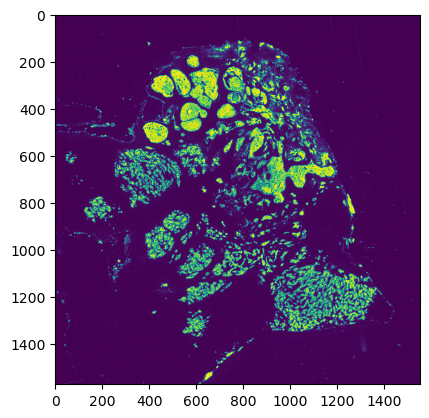

In [12]:
plt.imshow(thumbnail[channels.index('Pan-Cytokeratin')])

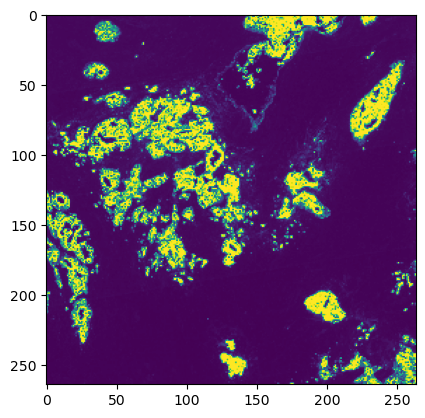

In [13]:
plt.imshow(thumbnail[channels.index('Pan-Cytokeratin'), 500:764, 500:764])

In [14]:
class MAETransform(object):
    def __init__(self, size=(256, 256), normalize=None):
        self.transforms = Compose([
            RandomCrop(size, padding_mode='reflect'),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            normalize if normalize is not None else nn.Identity()
        ])

    def __call__(self, x):
        return self.transforms(x)


class SlideDataset(Dataset):
    def __init__(self, slide_to_img, transform=None):
        self.slides = sorted(slide_to_img.keys())
        self.slide_to_img = slide_to_img

        self.transform = transform if transform is not None else nn.Identity()

    def __len__(self):
        return np.iinfo(np.int64).max # make infinite

    def __getitem__(self, idx):
        slide = np.random.choice(self.slides)
        idx = self.slides.index(slide)
        return {
            'slide_idx': idx,
            'img': transform(self.slide_to_img[slide])
        }

In [15]:
means = torch.cat([x.mean(dim=(-2, -1)).unsqueeze(0) for x in slide_to_img.values()]).mean(0)
stds = torch.cat([x.std(dim=(-2, -1)).unsqueeze(0) for x in slide_to_img.values()]).mean(0)
means, stds

(tensor([ 1.9242,  0.4242,  1.5283,  4.9701, 19.0076,  4.8628, 21.0575]),
 tensor([ 4.6411,  2.7208, 11.1956,  9.9388, 52.9554, 21.8240, 44.8913]))

In [16]:
size = (256, 256)

normalize = Normalize(means, stds)
transform = MAETransform(normalize=normalize)
ds = SlideDataset(slide_to_img, transform=transform)

In [17]:
d = ds[0]
tile = d['img']
slide_idx = d['slide_idx']
slide_idx

1

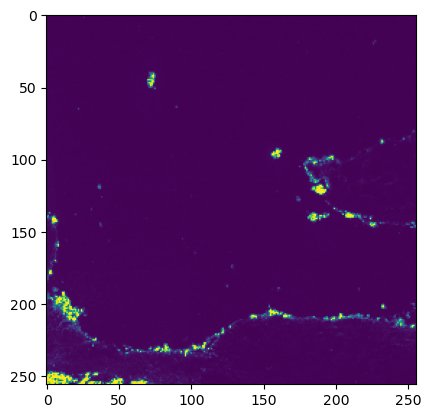

In [19]:
plt.imshow(tile[channels.index('Pan-Cytokeratin')])

In [20]:
dl = DataLoader(ds, batch_size=64, num_workers=10)

In [21]:
v = ViT(
    image_size = size[0],
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    channels=len(channels),
)

In [22]:
mae = SlideMAE(
    encoder = v,
    n_slides = len(slide_to_img),
    masking_ratio = 0.25,   # the paper recommended 75% masked patches
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 6       # anywhere from 1 to 8
)

In [23]:
v = v.cuda()
mae = mae.cuda()

In [24]:
iters = 100000
lr = 1e-4
opt = torch.optim.Adam(mae.parameters(), lr=lr)

In [25]:
!mkdir -p ../data/mae_v2

In [ ]:
for i, b in enumerate(dl):
    opt.zero_grad()
    
    slide_idxs, imgs = b['slide_idx'], b['img']
    slide_idxs, imgs = slide_idxs.cuda(), imgs.cuda()
    loss, _ = mae(imgs, slide_idxs)
    loss.backward()
    opt.step()
    
    if i % 100 == 0:
        print(i, loss)
        
    if i % 1000 == 0:
        torch.save(v.state_dict(), f'../data/mae_v2/{i}iter.pt')
        
    if i == iters:
        break

0 tensor(1.8747, device='cuda:0', grad_fn=<MseLossBackward0>)
100 tensor(1.6075, device='cuda:0', grad_fn=<MseLossBackward0>)
200 tensor(1.2414, device='cuda:0', grad_fn=<MseLossBackward0>)
300 tensor(1.3025, device='cuda:0', grad_fn=<MseLossBackward0>)
400 tensor(1.0569, device='cuda:0', grad_fn=<MseLossBackward0>)
500 tensor(0.9703, device='cuda:0', grad_fn=<MseLossBackward0>)
600 tensor(1.0245, device='cuda:0', grad_fn=<MseLossBackward0>)
700 tensor(1.0333, device='cuda:0', grad_fn=<MseLossBackward0>)
800 tensor(1.0260, device='cuda:0', grad_fn=<MseLossBackward0>)
900 tensor(1.0202, device='cuda:0', grad_fn=<MseLossBackward0>)
1000 tensor(1.1845, device='cuda:0', grad_fn=<MseLossBackward0>)
1100 tensor(1.1702, device='cuda:0', grad_fn=<MseLossBackward0>)
1200 tensor(1.1948, device='cuda:0', grad_fn=<MseLossBackward0>)
1300 tensor(1.0134, device='cuda:0', grad_fn=<MseLossBackward0>)
1400 tensor(1.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
1500 tensor(1.2452, device='cuda:0', 

12600 tensor(1.0961, device='cuda:0', grad_fn=<MseLossBackward0>)
12700 tensor(1.1280, device='cuda:0', grad_fn=<MseLossBackward0>)
12800 tensor(1.0645, device='cuda:0', grad_fn=<MseLossBackward0>)
12900 tensor(0.9591, device='cuda:0', grad_fn=<MseLossBackward0>)
13000 tensor(1.0659, device='cuda:0', grad_fn=<MseLossBackward0>)
13100 tensor(1.0962, device='cuda:0', grad_fn=<MseLossBackward0>)
13200 tensor(0.9908, device='cuda:0', grad_fn=<MseLossBackward0>)
13300 tensor(0.8616, device='cuda:0', grad_fn=<MseLossBackward0>)
13400 tensor(0.9707, device='cuda:0', grad_fn=<MseLossBackward0>)
13500 tensor(1.0061, device='cuda:0', grad_fn=<MseLossBackward0>)
13600 tensor(1.0512, device='cuda:0', grad_fn=<MseLossBackward0>)
13700 tensor(1.0072, device='cuda:0', grad_fn=<MseLossBackward0>)
13800 tensor(0.9816, device='cuda:0', grad_fn=<MseLossBackward0>)
13900 tensor(0.8996, device='cuda:0', grad_fn=<MseLossBackward0>)
14000 tensor(1.0302, device='cuda:0', grad_fn=<MseLossBackward0>)
14100 tens

25100 tensor(0.9725, device='cuda:0', grad_fn=<MseLossBackward0>)
25200 tensor(0.9288, device='cuda:0', grad_fn=<MseLossBackward0>)
25300 tensor(0.8248, device='cuda:0', grad_fn=<MseLossBackward0>)
25400 tensor(0.9570, device='cuda:0', grad_fn=<MseLossBackward0>)
25500 tensor(0.8373, device='cuda:0', grad_fn=<MseLossBackward0>)
25600 tensor(0.9155, device='cuda:0', grad_fn=<MseLossBackward0>)
25700 tensor(0.8752, device='cuda:0', grad_fn=<MseLossBackward0>)
25800 tensor(0.9813, device='cuda:0', grad_fn=<MseLossBackward0>)
25900 tensor(0.9696, device='cuda:0', grad_fn=<MseLossBackward0>)
26000 tensor(0.9660, device='cuda:0', grad_fn=<MseLossBackward0>)
26100 tensor(0.8560, device='cuda:0', grad_fn=<MseLossBackward0>)
26200 tensor(0.9325, device='cuda:0', grad_fn=<MseLossBackward0>)
26300 tensor(0.8152, device='cuda:0', grad_fn=<MseLossBackward0>)
26400 tensor(0.8426, device='cuda:0', grad_fn=<MseLossBackward0>)
26500 tensor(0.8915, device='cuda:0', grad_fn=<MseLossBackward0>)
26600 tens

In [ ]:
from vit_pytorch.extractor import Extractor
v = Extractor(v)

# forward pass now returns predictions and the attention maps

img = torch.randn(1, 3, 256, 256)
logits, embeddings = v(img)

In [71]:
images = torch.randn(8, 3, 256, 256)

In [73]:
slides = torch.randint(0, 10, (8,))

In [78]:
loss = mae(images, slides)

In [79]:
loss

tensor(1.8420, grad_fn=<MseLossBackward0>)

In [80]:
loss.backward()